# Imports

In [25]:
#Import cluster algorithms
from sklearn.cluster import KMeans, DBSCAN

#Import classifiers
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection as mod_selec
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Import 
import tensorflow as tf


#Import libraries to deal with data
import numpy as np
import pandas as pd
import pickle


#Process data libraries
from skimage import io
from scipy import signal
import pylab, wave
from scipy.io import wavfile

#Miscelanous
import math
import time
import os
import warnings


#Graphs and show images
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches



np.random.seed(10)
np.set_printoptions(suppress=True)
warnings.filterwarnings('ignore')
%matplotlib inline 


# Set up el dataset y las funciones

Dataset

In [26]:
dataset_path = os.path.abspath('kaggle_audios')

Funciones de spectograma

In [27]:
##############################################
#                                            #
#                Spectrogram                 #
#                                            #
##############################################
#Function to retrieve data from wav files
def wavInfo(rec_file):
    sample_rate, samples = wavfile.read(rec_file)
    channels  = wave.open(rec_file, 'r').getnchannels()
    return sample_rate, samples, channels


#Function to calcualte spectrogram
def specInfo(rec_file):
    sampleRate, samples, channels = wavInfo(rec_file)
    
    #Solution for one channels
    if(channels == 1):
        freqs, t, spectrum  = signal.spectrogram(samples[:], nfft=512, window="hann", fs=sampleRate)
        
    #Solution for two channels
    elif(channels == 2):
        freqs, t, spetctrum = signal.spectrogram(samples[:, 1], nfft=512, window="hann", fs=sampleRate)
        
        spectrum = spectrum.astype("float64") 
    return t,freqs,spectrum

##############################################
#                                            #
#              Image/Plotting                #
#                                            #
##############################################
def plotModSpecSimple(times, freqs, specMod, figsize = (8,4), xlab = "", ylab = "", title = "", colorbar = True, patch = None, cmap = "Purples"):
    """ 
        Function to plotspectrograms and bounding boxes in spectrograms
        Input:
            times - np array containing time steps (shape X,1)
            freqs - np array containing frequency steps (shape Y,1)
            specMod - np array containing magnitude values on each time step for each frequency (shape - (Y,X))
            figsize - list containing width and height size for the figure
            xlab - string containining label for x axis
            ylab - string contaiing label for y axis
            title - string containing title for the graph
            colorbar - bool value to decide whether graph should contain colorbar graph or not
            patch - array containing matplotlib.patches to be applied to the plot
            cmap - cmap for color displaying
    """
    
    
    fig, ax = pylab.subplots(1,1, figsize = figsize)
    ax.set_facecolor("grey")
    im = ax.pcolormesh(times, freqs,(specMod), cmap= cmap)
    
    #Plot spectrogram information given
    ax.pcolormesh(times, freqs,(specMod), cmap= cmap)
    
    #Add all patches to figure, if any
    if (patch !=None ):
        for i in patch:
            ax.add_patch(i)
    
    #Set x axis label
    ax.set_xlabel(xlab)
    
    #Set y axis label
    ax.set_ylabel(ylab)
    
    #Set title label
    ax.set_title(title)
    
    #Set colorbar if wanted
    if(colorbar):
        fig.colorbar(im, ax=ax)
    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##############################################
#                                            #
#              Data processing               #
#                                            #
##############################################



def Filter(array, Min, Max):
    '''Given a Min or Max parameter, find the index in the array that corresponds to the given Min or Max value
    #Example  [1,4,7,11], Min:5, Max 8, Output = (1,3)
    Input: 
        array: nparray containing information
        min  : float containing the minimum value to be found in array
        max  : float containing the maximum value to be found in array
    '''
    try:
        Min = (np.abs(array-Min)).argmin()
        Max = (np.abs(array-Max)).argmin()+1
    
        return Min, Max
    
    except:
        print("error: array input is not an nparray")
        
        



def getMarcaFromSpectrogram(t, freq, spec, minf, maxf, startT, endT, timeIndex):
    
    #Find index of the time in the array 
    startI, endI= Filter(t, startT, endT)
    
    #ind index of the frequencies in the array    
    minfreqI, maxfreqI = Filter(freq, minf, maxf)
    
    
    tSelect = t[startI:endI]
    freqSelect = freq[minfreqI:maxfreqI]
    if endI - startI > timeIndex:
        endI = startI+timeIndex
        
    mags = [spec[minfreqI][startI:endI]]
        
    for i in range(minfreqI+1, maxfreqI):
        mags = mags + [spec[i][startI:endI]]  
    specSelect = np.array(mags)
    
    return tSelect, freqSelect, specSelect, minfreqI, maxfreqI


def newSlicing(array, lowerIdx, upperIdx, step):
    resultingArray = np.array(array[lowerIdx:upperIdx])
    for i in range(upperIdx,len(array)+1,step):
        lowerIdx += step
        upperIdx+= step
        resultingArray = np.concatenate([resultingArray, array[lowerIdx:upperIdx]])

    return resultingArray

def orderClusters(flatCluster, flatSpectrogram, num, getGroups = False ):
    """Function to order the clusters according to the magnitude values
       Returns a vector containing the indeces of each cluster, where the 
       indeces identify which cluster is stronger in terms of magnitude(relative to spectrum)
    
       Input:
           flatCluster: Array containing flattened spectrogram's shape with cluster entries
           flatSpectrogram
    """
    
    minS = [None]*num
    maxS = [None]*num
    smallVal = np.array([])
    
    #
    for i in range(num):
        #identify each cluster
        idx = np.where(flatCluster ==i )
        
        #Find min and max values of each cluster
        minS[i] = min(flatSpectrogram[idx])
        maxS[i] = max(flatSpectrogram[idx])
        
        #Store the min value, so we can order the clusters according to the corresponding value
        smallVal = np.append(smallVal, minS[i])
        
    #Create buffer that will contain the cluster identifier information
    returnCluster = np.zeros(flatCluster.shape)
    
    #Fill the buffer containing the cluster identifier in ordered shape (min to max)
    for ctr, i in enumerate(np.argsort(smallVal)):
        idx = np.where(flatCluster == i)
        returnCluster[idx] = ctr
        

    del minS, smallVal, idx
    if getGroups:
        return returnCluster,maxS
    return returnCluster


#MISC

class Error(Exception):
    """Base class for exceptions in this module."""
    
    pass

[0.00266667 0.00733333 0.012      ... 6.984      6.98866667 6.99333333]
1499
Spectrogram calculation time: 0.028019428253173828 seconds


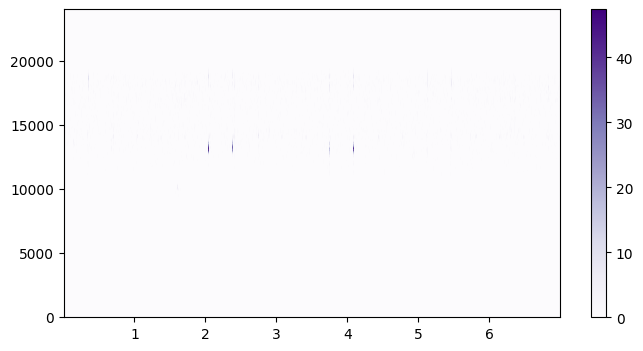

In [28]:
#audio file path
path = "2fa556c68_14.0_21.0_7.0_med|high_10800_19200.wav"

# open the wav
sr, wav = wavfile.read(path)

# convert data to int16
wav = wav.astype(np.int16)

# save the wav file with the same name
wavfile.write(path, sr, wav)



maxFreqForInterval = 13687.5

#Get spectrogram data
calculateSpecT = time.time()
t,freq,spec = specInfo(path)
frequencyLimit = ((np.abs(freq - maxFreqForInterval)).argmin()+1)
print(t)
print(len(t))
print("Spectrogram calculation time:", time.time()- calculateSpecT, "seconds")#outputs spectrogram calculation time
#Plot spectrogram dataspecInfo
plotModSpecSimple(t,freq,spec)

In [29]:
dataDescription = pd.read_csv("grabaciones_comptencia_kaggle.csv") 
dataDescription.head()

,marca_id,grabacion_id,archivo,punto_id,especie_id,tiempoi,tiempof,freqme,freqma,maxpot
0,0,0,003bec244_14_1.wav,0,13,44.5440,45.1307,2531.25,5531.25,0
1,0,0,006ab765f_23_1.wav,0,0,39.9615,46.0452,7235.16,11283.40,0
2,0,0,007f87ba2_12_1.wav,0,8,39.1360,42.2720,562.50,3281.25,0
3,0,0,007f87ba2_20_1.wav,0,23,9.8880,13.3280,2343.75,5718.75,0
4,0,0,007f87ba2_9_1.wav,0,21,5.5733,8.3787,1125.00,5250.00,0


In [30]:
MarkIndex = 0
file = dataDescription['archivo'][MarkIndex]
minimumFrequency = dataDescription['freqme'][MarkIndex]
maximumFreqeuency = dataDescription['freqma'][MarkIndex]
startTime = dataDescription['tiempoi'][MarkIndex]
endTime = dataDescription['tiempof'][MarkIndex]
print(file)
print(minimumFrequency)
print(maximumFreqeuency)
print(startTime)
print(endTime)

#Set a default value for Duration of mark 
# revisar
#milliseconds???????????????????????   
durationTime = 460

003bec244_14_1.wav
2531.25
5531.25
44.544
45.1307


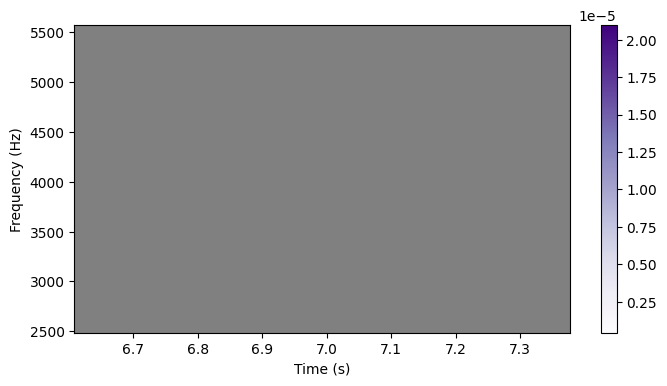

In [31]:
#Get spectrogram information of mark
tSelect, freqSelect, specSelect, minFreq, maxFreq = getMarcaFromSpectrogram(t,freq,spec, minimumFrequency,maximumFreqeuency, startTime,endTime, durationTime)

#Plot the mark
plotModSpecSimple(tSelect, freqSelect, specSelect, ylab = "Frequency (Hz)", xlab = "Time (s)")

In [32]:
#Define clusters and kmeans cluster instace
clusters = 6
kCluster = KMeans(clusters)

#First we must flatten the data to cluster it (1 dimensional vector)
specSelectFlatten = specSelect.flatten().reshape(-1,1)

Y axis in this plot is a density proportion of the count for each bin in magnitude values


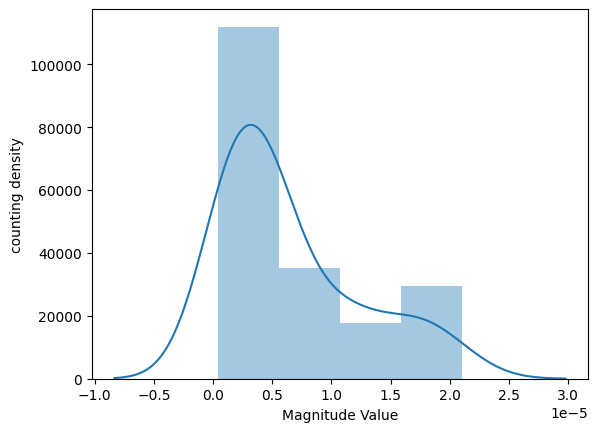

In [33]:
#Plot a histogram of magnitude values
ax = sns.distplot(specSelectFlatten, hist = True, norm_hist=False, axlabel= "Magnitude Value")
ax.set_ylabel("counting density")
print("Y axis in this plot is a density proportion of the count for each bin in magnitude values")

In [34]:

#Cluster the magnitude values
#The returning vector will contain the cluster group associated to each entry 
specSelectFlattenCluster = kCluster.fit_predict(specSelectFlatten)

In [35]:
#Make sure we order labels based on cluster's magnitude
specSelectFlattenCluster, clusterMax = orderClusters(specSelectFlattenCluster, specSelectFlatten, clusters,  True)

Text(0.5, 0, 'Magnitude values')

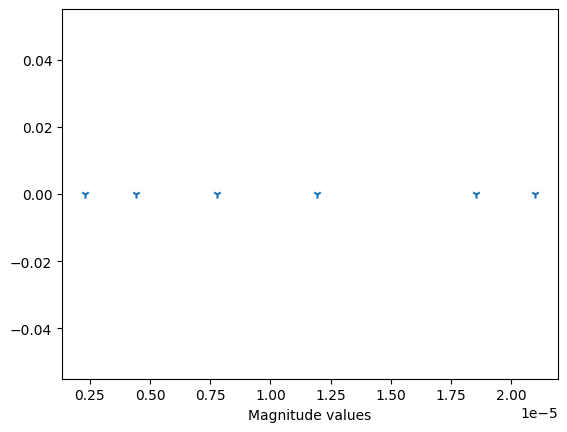

In [36]:
#Representation of clusters, between each marker is a cluster group
plt.scatter(np.concatenate(clusterMax), [[0]*clusters], marker = "1")
plt.xlabel("Magnitude values")


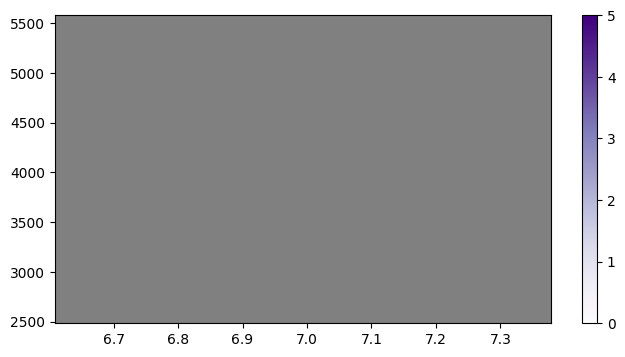

In [37]:
#Display how mark looks like after clutering magnitude values
plotModSpecSimple(tSelect,freqSelect , specSelectFlattenCluster.reshape(specSelect.shape))

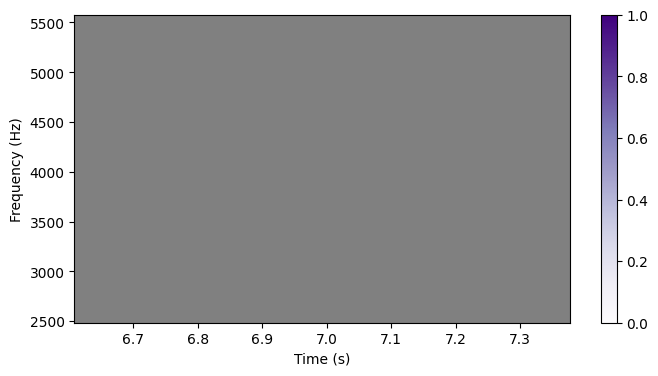

In [38]:
#Prepare data
#Set all values other than 0 to 1 
correctingIdx = np.where(specSelectFlattenCluster != 0)[0]
copySelectFlattenCluster = specSelectFlattenCluster
specSelectFlattenCluster = np.zeros(specSelectFlatten.shape)

#Set all values not equal to 0 to 1. 
specSelectFlattenCluster[correctingIdx] = 1
plotModSpecSimple(tSelect,freqSelect , specSelectFlattenCluster.reshape(specSelect.shape),  ylab = "Frequency (Hz)", xlab = "Time (s)")

In [39]:
#Get coordinates of relevant points (Coordinates of those values containing 1)
yIndeces, xIndeces = np.where(specSelectFlattenCluster.reshape(specSelect.shape) ==  1)
coordinatesArray = np.array([yIndeces, xIndeces]).T


In [40]:
#Define DBScan instace
DBScan = DBSCAN(eps = 2, min_samples = 8)

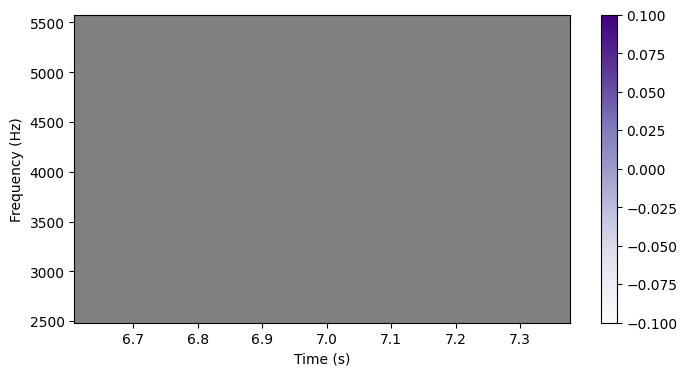

In [41]:
detectedGroups = DBScan.fit_predict(coordinatesArray)

#Get min and max groups (if min = -1, some points where not clustered) max will contain the number of cluster groups found
minIndex = np.min(detectedGroups)


#In order to have a range from 0 to 1, add abs value of minIndex ( if min index = 0 , it will remain the same
#if minIndex == -1, it will relocate range from 0 to maxIndex+1)
copySelectFlattenCluster[correctingIdx] = detectedGroups + abs(minIndex)
detectedGroups += abs(minIndex)
plotModSpecSimple(tSelect,freqSelect,copySelectFlattenCluster.reshape(specSelect.shape), xlab = "Time (s)", ylab = "Frequency (Hz)")

displayGroups = np.zeros(specSelect.shape)

for ctr, i in enumerate(coordinatesArray):
    displayGroups[int(i[0])][ int(i[1])] = detectedGroups[ctr]
maxIndex = np.max(detectedGroups)

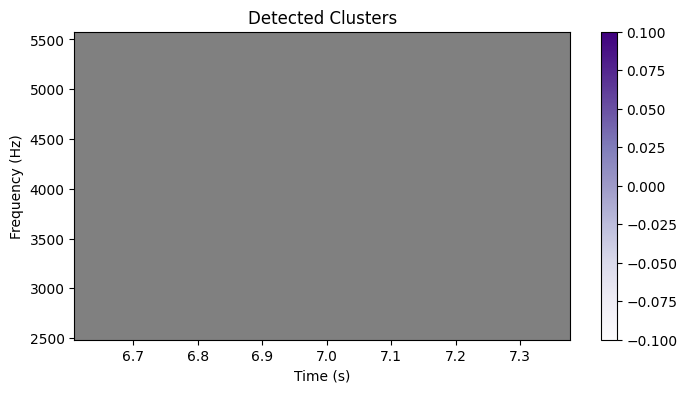

In [42]:
rect = []
for speechValue in range(1, maxIndex+1):
    if len(np.where(detectedGroups== speechValue)[0]) != 0 :
        
        #Get min and max time and frequency values of the identified cluster groups
        minf = np.min(np.where(displayGroups == speechValue)[0])
        maxf = np.max(np.where(displayGroups == speechValue)[0])
        startT = np.min(np.where(displayGroups == speechValue)[1])
        endT = np.max(np.where(displayGroups == speechValue)[1])

        #Create bounding box and add to boxes to be displayed
        rect.append(patches.Rectangle((tSelect[startT],freqSelect[minf]),tSelect[endT]-tSelect[startT],freqSelect[maxf]-freqSelect[minf],linewidth=1,edgecolor='g',facecolor='none'))

#Display marc with bounding boxes around the cluster groups found
plotModSpecSimple(tSelect,freqSelect,displayGroups, xlab = "Time (s)", ylab = "Frequency (Hz)", title = "Detected Clusters", patch = rect)


In [43]:
#Define training model parameters
#These two parameters are used to define how many time steps and frequencies will the training model have
timeInterval = 450
frequencyInterval = 86


for speechValue in range(1, maxIndex+1):
    speechIndexes = np.where(detectedGroups == speechValue)[0]

    minVal = np.min(coordinatesArray[speechIndexes], axis = 0)[1]

    trainMatrix = np.zeros((frequencyInterval ,timeInterval))

    for ctr, i in enumerate(coordinatesArray[speechIndexes]):
        if i[1] - minVal < timeInterval:
            trainMatrix[int(i[0])+minFreq][ int(i[1])-minVal] =1
    plotModSpecSimple(t[0:timeInterval], freq[0:frequencyInterval],trainMatrix, xlab = "Time (s)", ylab = "Frequency (Hz)")    

In [44]:
trainMatrix.shape

NameError: name 'trainMatrix' is not defined

Funcion para crear el dataset

In [ ]:
def transformDataset2( especieCounter,freqIndex, datasetcsv, timeIndex = 460  ,  frequencyInterval = 86, dbscanE = 2, dbscanMin = 8, kmeanCluster = 6, datasetPath = "kaggle_audios/"):
    DBScan = DBSCAN(eps = dbscanE, min_samples = dbscanMin)
    markLoad = []
    markLabel = []
    markFailed = []
    kCluster = KMeans(kmeanCluster)
    # trainMatrix = np.zeros((freqIndex, timeIndex), dtype = "int8")
    
#     cambiar aqui    
    dataset = pd.read_csv(datasetcsv)
    groupByFile = dataset.groupby("archivo")

    fctr = 0
    for eachFile in groupByFile:

        #Each file contains all the metadata ifilenformation for each file
            
        #Get file name from each file
        fileName = eachFile[0]
        
        t,freq, spec = specInfo(datasetPath + fileName)
        # print(t)
        # print("aqui")
        for idx, data in eachFile[1].iterrows():
            # try:

            minimumFrequency = data['freqme']
            maximumFreqeuency = data['freqma']
            startTime = data['tiempoi']
            endTime = data['tiempof']
            # print('aqui2')
            tSelect, freqSelect, specSelect, minFreq, maxFreq= getMarcaFromSpectrogram(t,freq,spec, minimumFrequency,maximumFreqeuency, startTime,endTime, timeIndex)
#                 return 0 

            #Cluster noise
            specSelectFlatten = specSelect.flatten().reshape(-1,1)

            # some values will index out of range, so we need to catch the error
            specSelectFlattenCluster = kCluster.fit_predict(specSelectFlatten)
            try:
                specSelectFlattenCluster, clusterMax = orderClusters(specSelectFlattenCluster, specSelectFlatten, kmeanCluster,  True)
            except:
                print("Error en ordenamiento de clusters en archivo: " + fileName)
                markFailed.append(fileName)
                continue

            # print('aqui3')
            correctingIdx = np.where(specSelectFlattenCluster != 0)[0]
            copySelectFlattenCluster = specSelectFlattenCluster
            specSelectFlattenCluster = np.zeros(specSelectFlatten.shape)

            #Set all values not equal to 0 to 1. 
            specSelectFlattenCluster[correctingIdx] = 1
            #plotModSpecSimple(tSelect,freqSelect , specSelectFlattenCluster.reshape(specSelect.shape),  ylab = "Frequency (Hz)", xlab = "Time (s)")

            #Get coordinates of relevant points (Coordinates of those values containing 1)
            yIndeces, xIndeces = np.where(specSelectFlattenCluster.reshape(specSelect.shape) ==  1)
            coordinatesArray = np.array([yIndeces, xIndeces]).T
            # print('aqui4')
            detectedGroups = DBScan.fit_predict(coordinatesArray)

            #Get min and max groups (if min = -1, some points where not clustered) max will contain the number of cluster groups found
            minIndex = np.min(detectedGroups)
            detectedGroups += abs(minIndex)
            maxIndex = np.max(detectedGroups)
            # print('aqui5')
            trainMatrix = np.zeros((frequencyInterval ,timeIndex), dtype = "int8")

            for speechValue in range(1, maxIndex+1):
                speechIndexes = np.where(detectedGroups == speechValue)[0]
                # print('aqui6')
                minVal = np.min(coordinatesArray[speechIndexes], axis = 0)[1]

                trainMatrix[:,:] = 0
                # print('aqui10')

                for ctr, i in enumerate(coordinatesArray[speechIndexes]):
                    # print('aqui7')
                    if (int(i[0])+minFreq) >= len(trainMatrix):
                        break
                    if i[1] - minVal < timeIndex:
                        # print('aqui7')
                        # print(len(trainMatrix))
                        # print(int(i[0])+minFreq)
                        trainMatrix[int(i[0])+minFreq][ int(i[1])-minVal] =1
            #plotModSpecSimple(t[0:timeInterval], freq[0:frequencyInterval],trainMatrix, xlab = "Time (s)", ylab = "Frequency (Hz)")    
                # print('aqui8')
                # print(type(especieCounter))
                especieCounter[data['especie_id']]+=1
                markLoad.append(trainMatrix)
                markLabel.append(data['especie_id'])
            # except Exception as e:
            #     # print the line number that threw the exception
            #     # print the code written in the line that threw the exception
            #     markFailed.append(idx)
            #     print("Marked failed: ", idx)
            #     print(e, "\n\n")
    markLabel = np.array(markLabel)
    markLoad = np.array(markLoad)
    
    #/order by species id
    idx = np.argsort(markLabel)
    markLoad[:] = markLoad[idx]
    markLabel[:] = markLabel[idx]

    return markLoad, markLabel, especieCounter

Set up random que no se que hace

Get amount of labels

In [ ]:
especieGroup = dataDescription.groupby('especie_id')

#Get especies ids and the size of "marcas" and get an index array to sort the order of species in terms
#of how many marcs they have
uniqueIDs = []
counter = []
for k,v in especieGroup.groups.items():
    uniqueIDs.append(k)
    counter.append(len(v))
idx = np.argsort(counter)
#Order the array based on "marcas" amount
uniqueIDs[:] = np.array(uniqueIDs)[idx]


especieConArchivo = dataDescription.groupby(['especie_id','archivo'])


#Contiene el nombre de todas las grabaciones usadas
grabaciones = []

#Grabaciones usadas en el training
aceptadas = []

#Diccionario que contiene el nombre de las grabaciones usadas de cada especie
grabacionName = {}
#Diccionario que contiene el counter de marcas por grabacion de cada especie
counterGrab = {}
#Diccionario para contar la cantidad de marcas que tenemos de cada especie
counterEspecie ={}
for k, v in (especieConArchivo.groups).items():
    #
    if k[0] not in grabacionName.keys():
        grabacionName[k[0]] = []
        counterGrab[k[0]] = []
        counterEspecie[k[0]] = 0 
    grabacionName[k[0]].append( k[1])
    counterGrab[k[0]].append(int(len(v)))
    if k[1] not in grabaciones:
        grabaciones.append(k[1])
    
#Ordenar las grabaciones dentro de cada especie por la cantidad de marcas que contienen
for k, v in counterGrab.items():
    sortByIndex = np.argsort(counterGrab[k])[::-1]
    #Convertir arreglos a np arrays para poder ordenarlos usando indexing (argsort)
    grabacionName[k] = np.array(grabacionName[k])
    counterGrab[k] = np.array(counterGrab[k])

    grabacionName[k][:] = grabacionName[k][sortByIndex]
    counterGrab[k][:] = counterGrab[k][sortByIndex]
    

#Buffer que contiene el minimo cantidad de marcas que queremos para training
finalCounter = 200
#El for loop irá de la especie con menos marcas a la que mas tiene 
for specie in uniqueIDs:
    #Ir por cada grabacion que tiene especie
    for ctr, grabacion in enumerate(grabacionName[specie]):

        #Verificar que la cantidad de marcas para training es mayor que "finalcounter"
        if counterEspecie[specie] < finalCounter:
            #Buscar la grabacion y la cantidad de marcas obtenidas de cada especie y añadirselo al counter
            for k,v in grabacionName.items():
                idx = np.where(v  == grabacion)[0]
                if len(idx) == 1 and grabacion in grabaciones:
                    counterEspecie[k] += counterGrab[k][idx]

            #Remover la grabacion usada
            if grabacion in grabaciones:
                grabaciones.remove(grabacion)
                aceptadas.append(grabacion)
        else:
            break
# print(counterEspecie)
# print(len(grabaciones))
# print(len(aceptadas))

#Elimina grabaciones usadas en training
marcasTesting = dataDescription
for i in aceptadas:
    if i in marcasTesting['archivo'].unique():
        idx = (marcasTesting.index[marcasTesting['archivo'] == i])
        marcasTesting = marcasTesting.drop(idx)
# print(len(marcasTesting['archivo'].unique()))

#Eliminar grabaciones no usadas en training
marcasTraining =  dataDescription
print(marcasTraining.shape)
for i in grabaciones:
    if i in marcasTraining['archivo'].unique():
        idx = (marcasTraining.index[marcasTraining['archivo'] == i])
        print(idx)
#         print(idx)
        marcasTraining = marcasTraining.drop(idx)
#         print(marcasTraining.shape)
# print(len(marcasTraining['archivo'].unique()))

#Identificar la cantidad minima de marcas que unmarcasTraininga especie tiene
minMarcas = min(marcasTraining.groupby("especie_id").size())
# print(marcasTraining.groupby("especie_id").size())
trainingMarcas = minMarcas
trainingFinal = marcasTraining.groupby('especie_id').apply(lambda x: x.sample( trainingMarcas, random_state= 10))
# trainingFinal.groupby("especie_id").size()
# print(trainingFinal)
# print(trainingFinal.shape)

#Identificar training set (para evaluar los modelos)

# minMarcas = min(marcasTesting.groupby("especie_id").size())
# print(marcasTesting.groupby("especie_id").size(), minMarcas)
# testingMarcas = minMarcas
# testingFinal = marcasTesting.groupby('especie_id').apply(lambda x: x.sample( testingMarcas, random_state= 10))
# testingFinal.groupby("especie_id").size()

# get length of dict
print(len(counterEspecie))

(290, 10)
26


In [ ]:
# # maxFreqForInterval = 8000

# dataDescription = pd.read_csv("grabaciones_comptencia_kaggle.csv") 
# # speciesID = dataDescription['especie_id'].unique()[:-1]#gives array of all species in csv

#     #Since we are only using the 8000 frequencies and below, remove species outside the bounds ##why are we only using freqs < 8000
# dataDescription = dataDescription.groupby('especie_id').filter(lambda x: max(x['freqma']) < 8000)


# indexes= dataDescription.index[dataDescription['especie_id'] == 12]
# dataDescription = dataDescription.drop(indexes).reset_index()
# print(dataDescription)
# indexes= dataDescription.index[dataDescription['especie_id'] == 10]
# dataDescription = dataDescription.drop(indexes).reset_index()
# np.sort(dataDescription['especie_id'].unique())
# # print(dataDescription.shape)

# maxtimeWithSTD = np.max(dataDescription.groupby('especie_id').apply(lambda x: (np.mean(x['tiempof']- x["tiempoi"]) +np.std(x['tiempof']- x["tiempoi"]))))
# t,freq,spec = specInfo("./kaggle_audios/0a9cdd8a5_7_1.wav")
# getTimeInterval = Filter(t, 0,maxtimeWithSTD)[1]
# frequencyLimit = ((np.abs(freq - maxFreqForInterval)).argmin()+1)
# timeLimit = ((np.abs(t - maxtimeWithSTD)).argmin()+1)

data_csv = pd.read_csv("grabaciones_comptencia_kaggle.csv") 
# get the unique amount of species_id in the csv
speciesID = data_csv['especie_id'].unique()[:-1]#gives array of all species in csv
print(speciesID.shape)
specied_id_amount = speciesID.shape[0]
print(specied_id_amount)

(25,)
25


Get amount of samples

In [ ]:
#get the 



In [ ]:
trainingDataset, trainingLabels, marcasEspecies = transformDataset2(especieCounter = counterEspecie,
                                                                     datasetcsv= "grabaciones_comptencia_kaggle.csv", 
                                                                     freqIndex=frequencyLimit)



In [ ]:
# print(testingFinal.shape)
print(trainingFinal.shape)
print(marcasEspecies)
key = list(marcasEspecies)
key = key[0]
print(key)
print(marcasEspecies[key])


(104, 10)
{0: array([403]), 1: array([273]), 2: array([178]), 3: array([76]), 4: array([295]), 5: array([222]), 6: array([142]), 7: array([280]), 8: array([406]), 9: array([155]), 10: array([58]), 11: array([164]), 12: array([98]), 13: array([127]), 14: array([180]), 15: array([319]), 16: array([365]), 17: array([203]), 18: array([253]), 19: array([499]), 20: array([917]), 21: array([233]), 22: array([110]), 23: array([109]), 24: array([85]), 25: array([399])}
0
[403]


In [ ]:
from sklearn import model_selection as mod_selec
from sklearn.model_selection import KFold
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(trainingLabels)
print(trainingDataset.shape)
print(trainingLabels.shape)
print(trainingLabels[0])

[ 0  0  0 ... 25 25 25]
(6125, 86, 460)
(6125,)
0


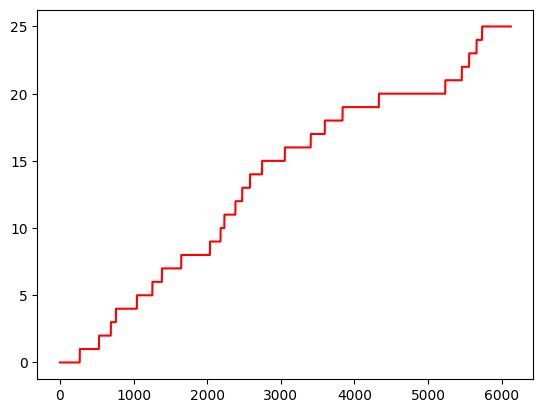

In [ ]:
plt.plot(trainingLabels, color="red")

In [ ]:
# Defining container to store score per-fold
acc_per_fold = []
print(np.unique(trainingLabels).shape[0])

26


In [ ]:
kf = KFold(n_splits=5)
kf.get_n_splits(trainingDataset)


for train_index, test_index in kf.split(trainingDataset):
    
    X_train, X_test = trainingDataset[train_index], trainingDataset[test_index]
    y_train, y_test = trainingLabels[train_index], trainingLabels[test_index]
    y_label = np.unique(y_train).shape[0]
    
    #define model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(86, 460)),
        tf.keras.layers.MaxPooling1D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_label, activation='softmax')
    ])
    
    #compile model
    model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    
    #set up one hot enconder used
    y_onehot = y_train.reshape((y_train.size, 1)) # can also use np.transpose,
    y_test_OneHot = y_test.reshape((y_test.size,1))
    onehot = OneHotEncoder(sparse=False, handle_unknown = 'ignore') #puts the lables in a vector
    y_hotenc = onehot.fit_transform(y_onehot)
    y_test_OneHotEnc = onehot.transform(y_test_OneHot)

    
    #fit data into model
    history =  model.fit(X_train,y_hotenc, epochs = 10)

    # Generate generalization metrics
    scores = model.evaluate(X_train, y_hotenc, verbose=0)
    acc_per_fold.append(scores[1] * 100)


Epoch 1/10
154/154 [==============================] - 1s 6ms/step - loss: 1.4681 - accuracy: 0.5592
Epoch 2/10
154/154 [==============================] - 1s 5ms/step - loss: 0.8597 - accuracy: 0.6827
Epoch 3/10
154/154 [==============================] - 1s 5ms/step - loss: 0.6764 - accuracy: 0.7392
Epoch 4/10
154/154 [==============================] - 1s 5ms/step - loss: 0.5774 - accuracy: 0.7763
Epoch 5/10
154/154 [==============================] - 1s 5ms/step - loss: 0.5193 - accuracy: 0.7910
Epoch 6/10
154/154 [==============================] - 1s 5ms/step - loss: 0.4855 - accuracy: 0.8024
Epoch 7/10
154/154 [==============================] - 1s 5ms/step - loss: 0.4665 - accuracy: 0.8057
Epoch 8/10
154/154 [==============================] - 1s 5ms/step - loss: 0.4526 - accuracy: 0.8092
Epoch 9/10
154/154 [==============================] - 1s 5ms/step - loss: 0.4470 - accuracy: 0.8118
Epoch 10/10
154/154 [==============================] - 1s 5ms/step - loss: 0.4406 - accuracy: 0.8137

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('--------------------------------------')
    print('Scope per fold')
    print(f'> Fold {i+1} - Accuracy: {acc_per_fold[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')


------------------------------------------------------------------------
Score per fold
--------------------------------------
Scope per fold
> Fold 1 - Accuracy: 81.48979544639587%
--------------------------------------
Scope per fold
> Fold 2 - Accuracy: 72.04081416130066%
--------------------------------------
Scope per fold
> Fold 3 - Accuracy: 71.24489545822144%
--------------------------------------
Scope per fold
> Fold 4 - Accuracy: 79.34693694114685%
--------------------------------------
Scope per fold
> Fold 5 - Accuracy: 77.16326713562012%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 76.25714182853699 (+- 4.016182104157628)
